In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

import torchviz

print(torch.cuda.is_available)


<function is_available at 0x000001F5448FF420>


In [11]:
class RegressionDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        self.n_samples = x_data.shape[0]
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

In [14]:
x_numpy = np.array([-1.5, -0.8, 0.1, 0.9, 1.7], dtype=np.float32)
y_numpy = np.array([0.3, -0.3, 0.5, 1.8, 1.5], dtype=np.float32)

x_input_tensor = torch.from_numpy(x_numpy).unsqueeze(1) # Add a dimension for features (N, 1)
y_target_tensor = torch.from_numpy(y_numpy).unsqueeze(1) # Add a dimension for features (N, 1)

print(x_input_tensor)
print(x_input_tensor.shape)
print(y_target_tensor)
print(y_target_tensor.shape)


dataset = RegressionDataset(x_input_tensor, y_target_tensor)
batch_size = len(dataset) # Use full batch size for the dataset
print(batch_size)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False) # shuffle=False as order doesn't matter for full batch

tensor([[-1.5000],
        [-0.8000],
        [ 0.1000],
        [ 0.9000],
        [ 1.7000]])
torch.Size([5, 1])
tensor([[ 0.3000],
        [-0.3000],
        [ 0.5000],
        [ 1.8000],
        [ 1.5000]])
torch.Size([5, 1])
5


In [20]:
class SimpleModelWParam(nn.Module):
    def __init__(self, init_weight=-10.0, init_bias=10.0):
        super().__init__()
        
        # Trainable Param
        self.weight = nn.Parameter(torch.tensor([init_weight], dtype=torch.float32))
        self.bias = nn.Parameter(torch.tensor([init_bias], dtype=torch.float32))
        
    def forward(self, x):
        return x * self.weight + self.bias
    
class SimpleModelWModule(nn.Module):
    def __init__(self, init_weight=-10.0, init_bias=10.0):
        super().__init__()
        
        self.linear = nn.Linear(in_features=1, out_features=1, bias=True)
        
        with torch.no_grad(): # Disable gradient calculation during init
            self.linear.weight.fill_(init_weight)
            self.linear.bias.fill_(init_bias)
            
    def forward(self, x):
        return self.linear(x)
    
model = SimpleModelWModule()

In [21]:
criterion = nn.MSELoss() # MSE (Mean Square Error)

optimizer = optim.SGD(model.parameters(), lr=0.1)
num_epochs = 50

losses = [] 
for epoch in range(num_epochs):
    for x_inputs, y_targets in dataloader:
        
        y_pred = model(x_inputs)
        loss = criterion(y_pred, y_targets)
        losses.append(loss.item())
        
        # perform a backward pass, and upate the parameter
        optimizer.zero_grad() # clear previous gradient of model.parameters(), zeroing gradient
        loss.backward()
        
        optimizer.step()
        
        if epoch == 0:
             # Visualizes the graph starting from the 'loss' tensor.
             # 'params' helps in labeling the nodes with parameter names.
             graph = torchviz.make_dot(loss, params=dict(model.named_parameters()))
             graph.render("autograd_graph", view=False) # Renders and optionally opens the graph file
            
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}: "
              f"w = {model.linear.weight.item():.4f}, "
              f"b = {model.linear.bias.item():.4f}, "
              f"Loss = {loss.item():.4f}"
)
        

Epoch 10: w = -0.0835, b = 1.8877, Loss = 3.0419
Epoch 20: w = 0.5153, b = 0.8525, Loss = 0.2208
Epoch 30: w = 0.5598, b = 0.7306, Loss = 0.1886
Epoch 40: w = 0.5638, b = 0.7166, Loss = 0.1882
Epoch 50: w = 0.5642, b = 0.7151, Loss = 0.1882


### Neural Network: Finding the Curve
* Types of Gradient Descent
  * Batch Gardient Descent
  * Stochastic Gradient Descent
  * Mini-Batch Gradient Descent

In [22]:
torch.manual_seed(2)
np.random.seed(2)

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: cuda


In [26]:
import altair as alt
import pandas as pd
import kagglehub
path = kagglehub.dataset_download("jayhingrajiya/auto-mpg-dataset-miles-per-gallon")
data = pd.read_csv(path + "/auto.csv")
data['horsepower'] = pd.to_numeric(data['horsepower'], errors='coerce')
data = data.dropna(subset=['horsepower', 'mpg'])  # Add this line

alt.Chart(data).mark_point().encode(
    # x=alt.X('weight', title='weight'),
    x=alt.X('horsepower', title='horsepower'),
    y=alt.Y('mpg', title='mpg'),
    color='origin',
    tooltip=['horsepower', 'mpg']
).interactive()  # Enables zooming and panning

c:\Users\skcjf\project\self-study\pytorch\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 6.50k/6.50k [00:00<00:00, 4.98MB/s]

Extracting files...


alt.Chart(...)

In [27]:
x_numpy = data['horsepower'].values.astype(np.float32)
y_numpy = data['mpg'].values.astype(np.float32)

# Normalize data
x_numpy = (x_numpy - x_numpy.mean()) / x_numpy.std()
y_numpy = (y_numpy - y_numpy.mean()) / y_numpy.std()

# Split indices (70% train, 15% val, 15% test)
n_samples = len(x_numpy)
indices = np.random.permutation(n_samples)

train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

# Create tensors for each split
x_train = torch.from_numpy(x_numpy[train_indices]).unsqueeze(1).to(device)
y_train = torch.from_numpy(y_numpy[train_indices]).unsqueeze(1).to(device)

x_val = torch.from_numpy(x_numpy[val_indices]).unsqueeze(1).to(device)
y_val = torch.from_numpy(y_numpy[val_indices]).unsqueeze(1).to(device)

x_test = torch.from_numpy(x_numpy[test_indices]).unsqueeze(1).to(device)
y_test = torch.from_numpy(y_numpy[test_indices]).unsqueeze(1).to(device)

# Create datasets
train_dataset = RegressionDataset(x_train, y_train)
val_dataset = RegressionDataset(x_val, y_val)
test_dataset = RegressionDataset(x_test, y_test)

# Create dataloaders
#batch_size = 32
batch_size = len(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [28]:
def train(model, num_epochs = 10000):
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.MSELoss()
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Train
        model.train()
        train_loss = 0.0
        for x_inputs, y_targets in train_loader:
            y_pred = model(x_inputs)
            loss = criterion(y_pred, y_targets)
            train_loss += loss.item() * len(x_inputs)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_loss /= len(train_dataset)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for x_inputs, y_targets in val_loader:
                y_pred = model(x_inputs)
                loss = criterion(y_pred, y_targets)
                val_loss += loss.item() * len(x_inputs)
            
            val_loss /= len(val_dataset)
            val_losses.append(val_loss)
        
        # if (epoch + 1) % (num_epochs // 10) == 0:
        #     print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')

    # torch.save(model.state_dict(), 'my_model.pth')
    # model.load_state_dict(torch.load('my_model.pth'))
    model.eval()

    # Calculate final losses
    with torch.no_grad():
        test_loss = 0.0
        for x_inputs, y_targets in test_loader:
            y_pred = model(x_inputs)
            loss = criterion(y_pred, y_targets)
            test_loss += loss.item() * len(x_inputs)
        test_loss /= len(test_dataset)

    print(f'Final Test Loss: {test_loss:.4f}')

    train_losses = train_losses[20:] # Loss가 너무 높은 앞부분 삭제
    val_losses = val_losses[20:]

    # Plot training curves and predictions
    plt.figure(figsize=(15, 5))

    # Loss curves
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    # Training data and predictions
    plt.subplot(1, 3, 2)
    plt.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), color='blue', alpha=0.5, label='Train')
    plt.scatter(x_val.cpu().numpy(), y_val.cpu().numpy(), color='red', alpha=0.5, label='Val')
    plt.scatter(x_test.cpu().numpy(), y_test.cpu().numpy(), color='yellow', alpha=0.5, label='Test')

    # Model predictions
    x_line = torch.linspace(torch.min(x_train), torch.max(x_train), 100).unsqueeze(1).to(device)
    y_line = model(x_line).detach().cpu().numpy()
    plt.plot(x_line.cpu().numpy(), y_line, color='black', label='Model')

    plt.title('Predictions vs Data')
    plt.xlabel('Normalized Horsepower')
    plt.ylabel('Normalized MPG')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Final Test Loss: 0.2728


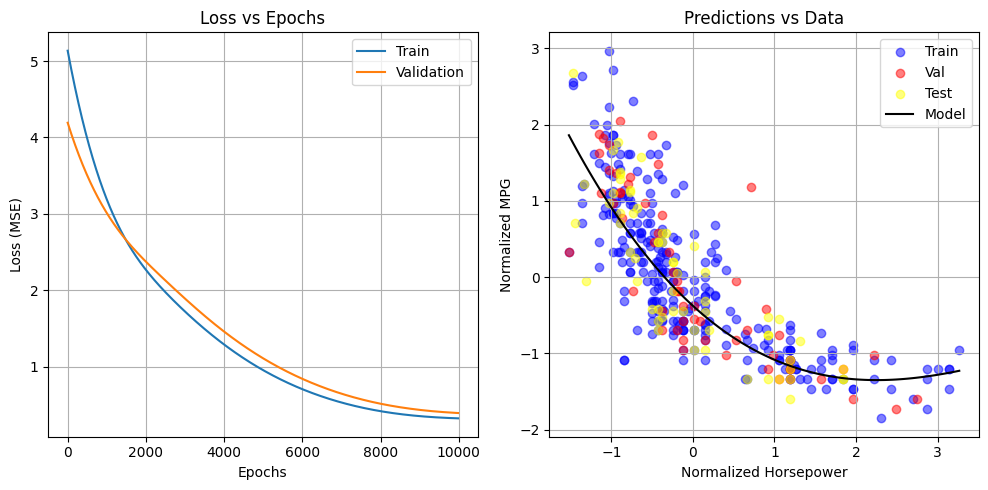

In [29]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Directly define parameters for y = a*x^2 + b*x + c
        self.a = nn.Parameter(torch.randn(1))
        self.b = nn.Parameter(torch.randn(1))
        self.c = nn.Parameter(torch.randn(1))
        self.d = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return self.a * x**3 + self.b * x**2 + self.c * x + self.d
    
train(SimpleModel().to(device))

Final Test Loss: 0.2702


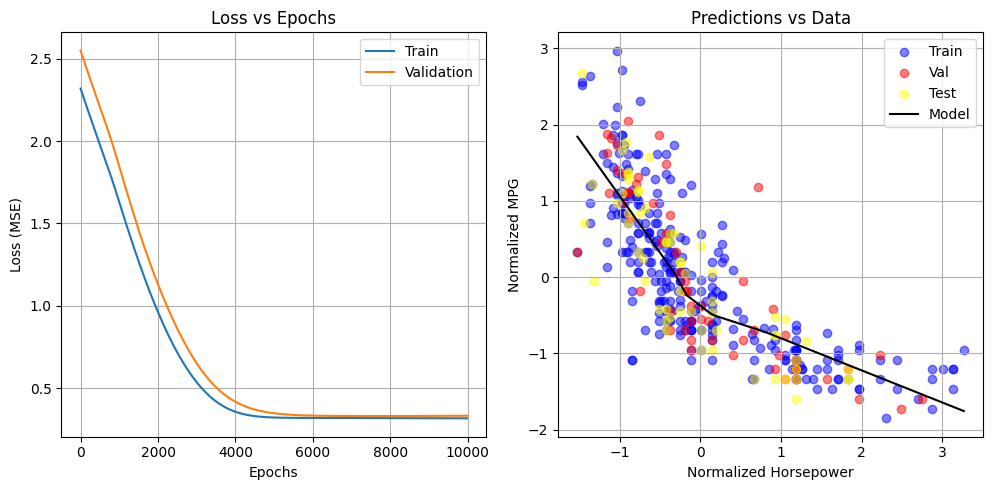

In [30]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_features=1, out_features=4, bias=True))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(in_features=4, out_features=1, bias=True))

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

train(SimpleModel().to(device))

Final Test Loss: 0.2618


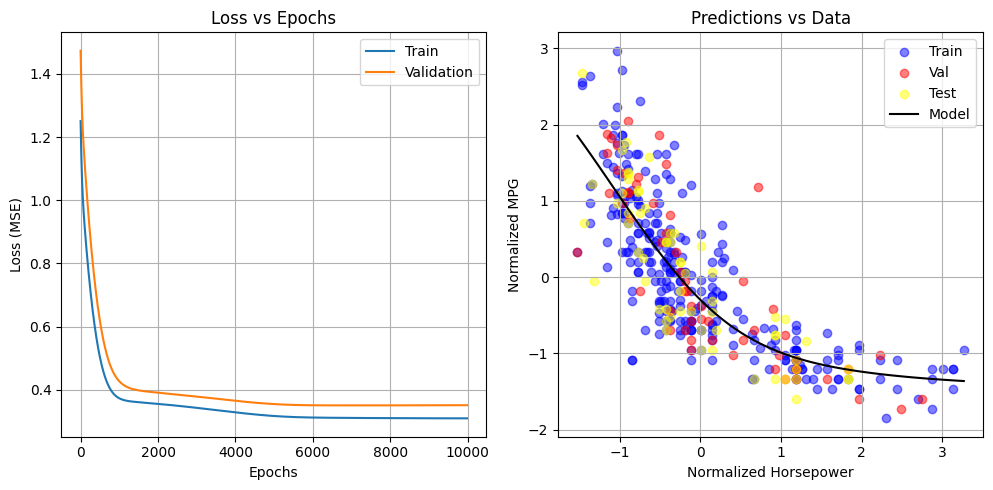

In [31]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_features=1, out_features=128, bias=True))
        self.layers.append(nn.Sigmoid())
        self.layers.append(nn.Linear(in_features=128, out_features=1, bias=True))

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

train(SimpleModel().to(device))

Final Test Loss: 0.2608


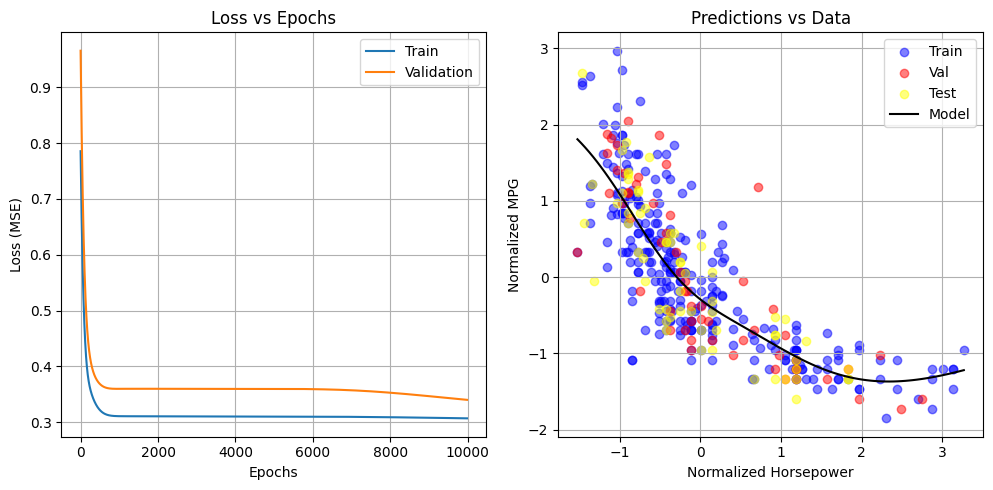

In [32]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_features=1, out_features=128, bias=True))
        self.layers.append(nn.GELU())
        self.layers.append(nn.Linear(in_features=128, out_features=1, bias=True))

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

train(SimpleModel().to(device))

Final Test Loss: 0.2574


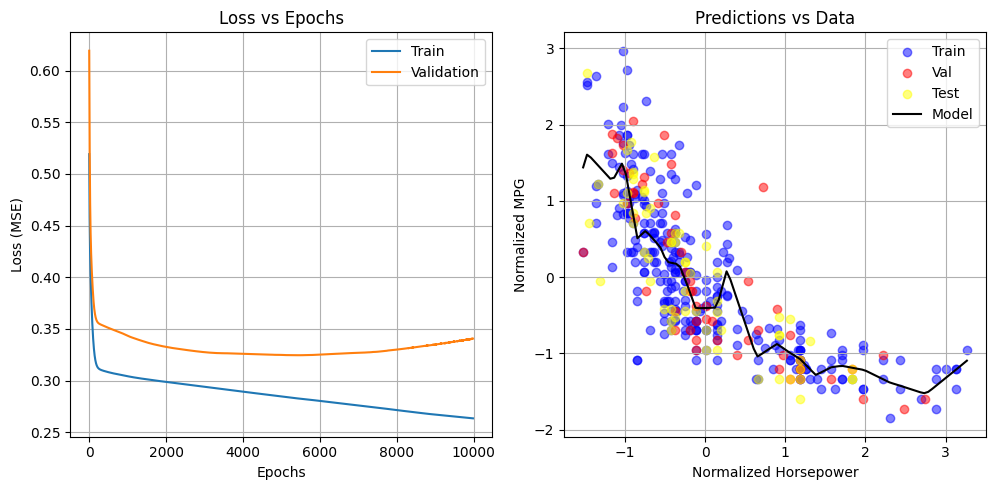

In [33]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_features=1, out_features=512, bias=True))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(in_features=512, out_features=1, bias=True))

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

train(SimpleModel().to(device))